In [222]:
import json
import pathlib
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.grid"] = True

FILES = [
    "out/config_Zendure2400_noBattery.json",
    "out/config_Zendure2400_2880kwh.json",
    "out/config_Zendure2400_5760kwh.json",
    "out/config_Zendure2400_8640kwh.json",
    "out/config_Zendure2400_11520kwh.json",
    "out/config_Zendure2400_14400kwh.json",
]

def load_json(path):
    with open(path, "r") as f:
        return json.load(f)
    
def battery_size_from_config(data) -> int:
    # total capacity across phases (Wh)
    return sum(data["configuration"]["battery"]["capacity_Wh_per_phase"])

Extract monthly data (cumulated phases)

In [223]:
MONTH_ROWS = []

for file in FILES:
    scenario = pathlib.Path(file).stem.replace("config_", "")
    data = load_json(file)

    battery_size_wh = battery_size_from_config(data)

    months = data.get("months", [])
    if not months:
        print(f"⚠️ No months section in {scenario}, skipping")
        continue

    for m in months:
        month_range = m.get("range", {})

        is_full_month = month_range.get("is_full_month", False)
        n_days = month_range.get("calendar_duration_days", 0)

        # 🚫 skip incomplete / short months
        if not is_full_month and n_days < 28:
            continue

        month_id = m["range_id"]
        results = m["results"]

        # ---- cumulate energy across phases ----
        energy = results.get("energy", {})
        injected = energy.get("injected", [])
        consumed = energy.get("consumed", [])

        injected_kwh = sum(abs(e["energy_kwh"]) for e in injected)
        consumed_kwh = sum(abs(e["energy_kwh"]) for e in consumed)

        injected_chf = sum(e["delta_chf"] for e in injected)
        consumed_chf = sum(e["delta_chf"] for e in consumed)

        rentability = results.get("rentability", {})

        MONTH_ROWS.append({
            "month": month_id,
            "scenario": scenario,
            "battery_size_wh": battery_size_wh,

            "gain_chf": rentability.get("total_gain_chf", 0.0),

            "grid_consumed_kwh": consumed_kwh,
            "grid_injected_kwh": injected_kwh,

            "grid_consumed_chf": consumed_chf,
            "grid_injected_chf": injected_chf,
        })

df_monthly = pd.DataFrame(MONTH_ROWS)

df_monthly["month"] = pd.to_datetime(df_monthly["month"])
df_monthly = df_monthly.sort_values(["battery_size_wh", "month"])

scenario_order = (
    df_monthly[["scenario", "battery_size_wh"]]
    .drop_duplicates()
    .sort_values("battery_size_wh")["scenario"]
    .tolist()
)


Monthly gain (CHF) graph

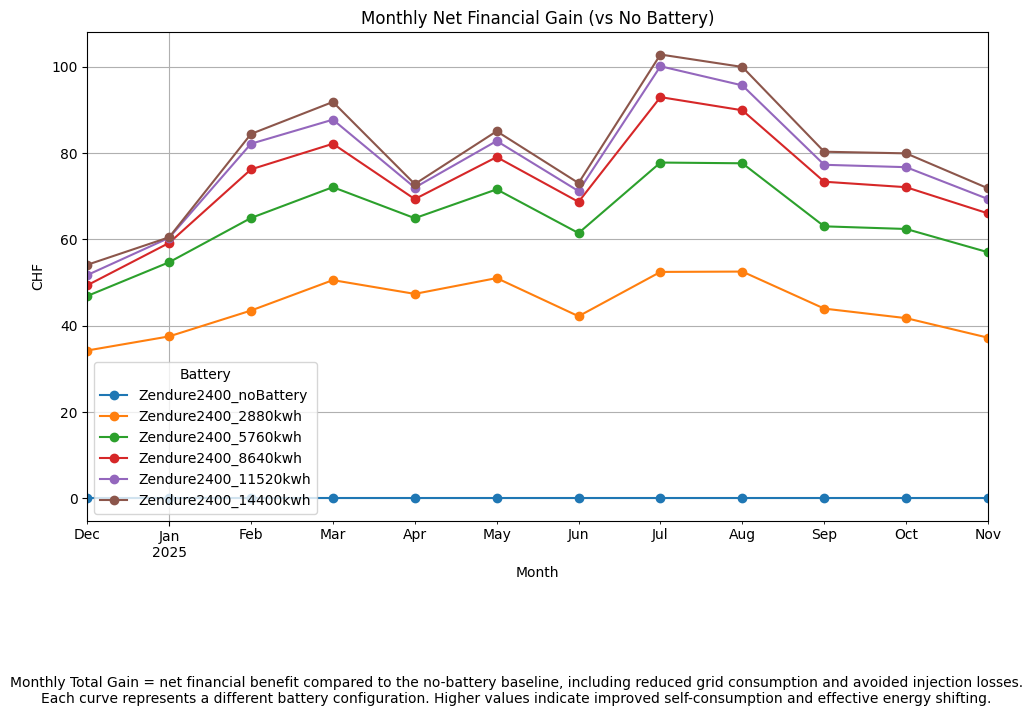

In [224]:
pivot_gain = df_monthly.pivot(
    index="month",
    columns="scenario",
    values="gain_chf"
)

pivot_gain = pivot_gain[scenario_order]

pivot_gain.plot(marker="o")
plt.title("Monthly Net Financial Gain (vs No Battery)")
plt.xlabel("Month")
plt.ylabel("CHF")
plt.legend(title="Battery")
plt.tight_layout()
plt.figtext(
    0.5, -0.18,
    "Monthly Total Gain = net financial benefit compared to the no-battery baseline, "
    "including reduced grid consumption and avoided injection losses.\n"
    "Each curve represents a different battery configuration. "
    "Higher values indicate improved self-consumption and effective energy shifting.",
    ha="center",
    fontsize=10
)
plt.show()


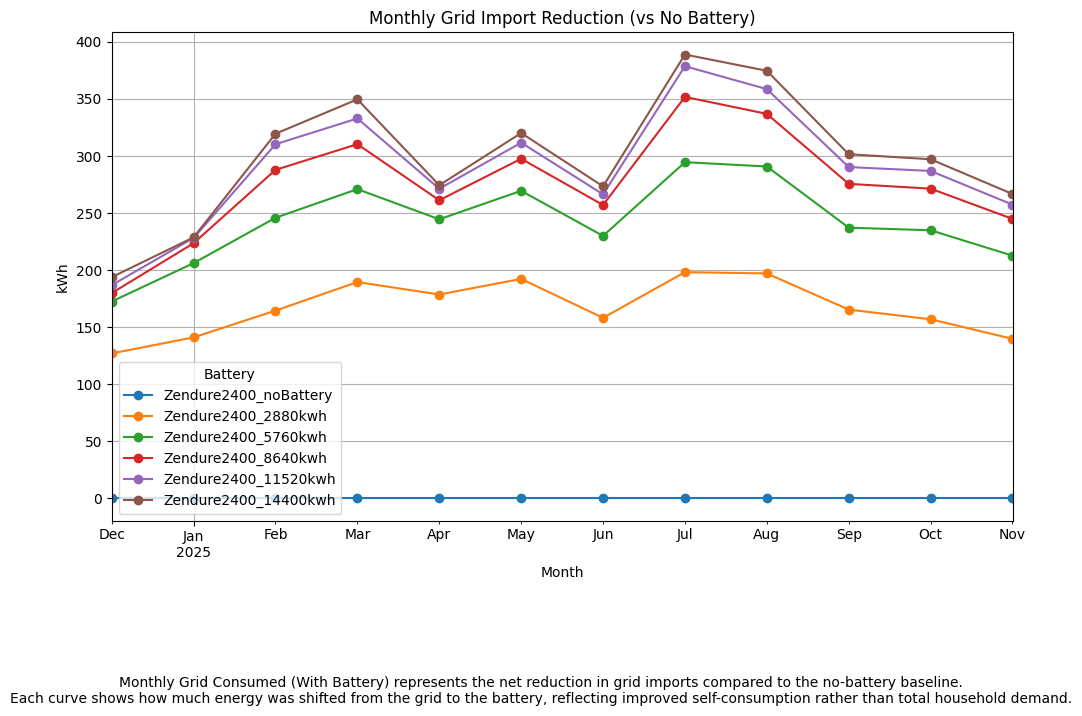

In [225]:
pivot_consumed = df_monthly.pivot(
    index="month",
    columns="scenario",
    values="grid_consumed_kwh"
)

pivot_consumed = pivot_consumed[scenario_order]

pivot_consumed.plot(marker="o")
plt.title("Monthly Grid Import Reduction (vs No Battery)")
plt.xlabel("Month")
plt.ylabel("kWh")
plt.legend(title="Battery")
plt.tight_layout()
plt.figtext(
    0.5, -0.18,
    "Monthly Grid Consumed (With Battery) represents the net reduction in grid imports "
    "compared to the no-battery baseline.\n"
    "Each curve shows how much energy was shifted from the grid to the battery, "
    "reflecting improved self-consumption rather than total household demand.",
    ha="center",
    fontsize=10
)
plt.show()


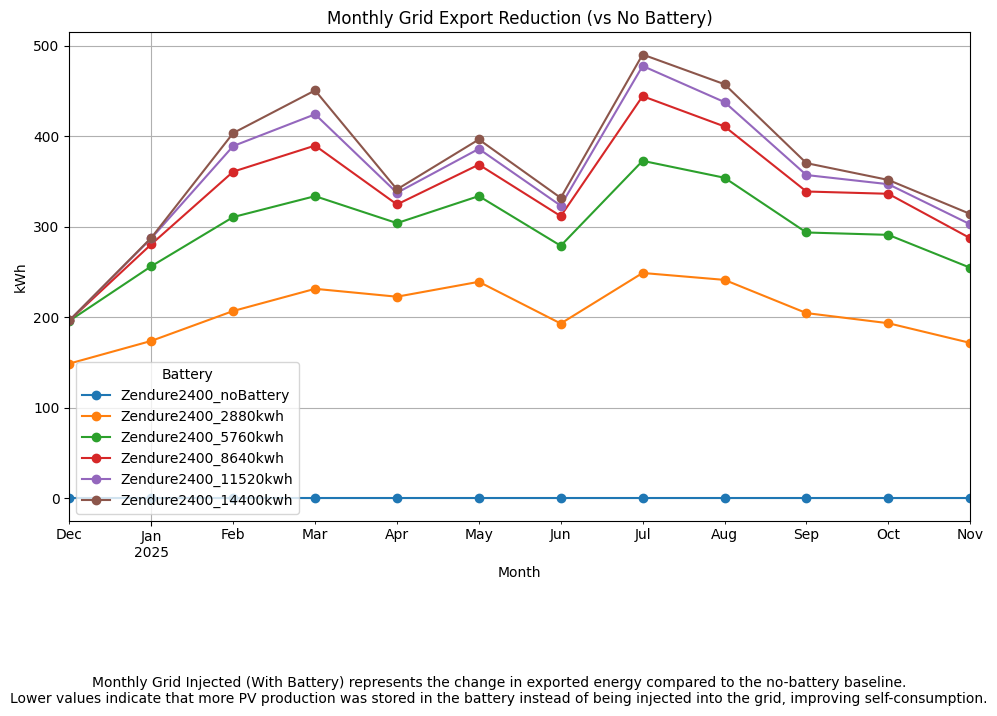

In [226]:
pivot_injected = df_monthly.pivot(
    index="month",
    columns="scenario",
    values="grid_injected_kwh"
)

pivot_injected = pivot_injected[scenario_order]

pivot_injected.plot(marker="o")
plt.title("Monthly Grid Export Reduction (vs No Battery)")
plt.xlabel("Month")
plt.ylabel("kWh")
plt.legend(title="Battery")
plt.tight_layout()
plt.figtext(
    0.5, -0.18,
    "Monthly Grid Injected (With Battery) represents the change in exported energy "
    "compared to the no-battery baseline.\n"
    "Lower values indicate that more PV production was stored in the battery "
    "instead of being injected into the grid, improving self-consumption.",
    ha="center",
    fontsize=10
)
plt.show()


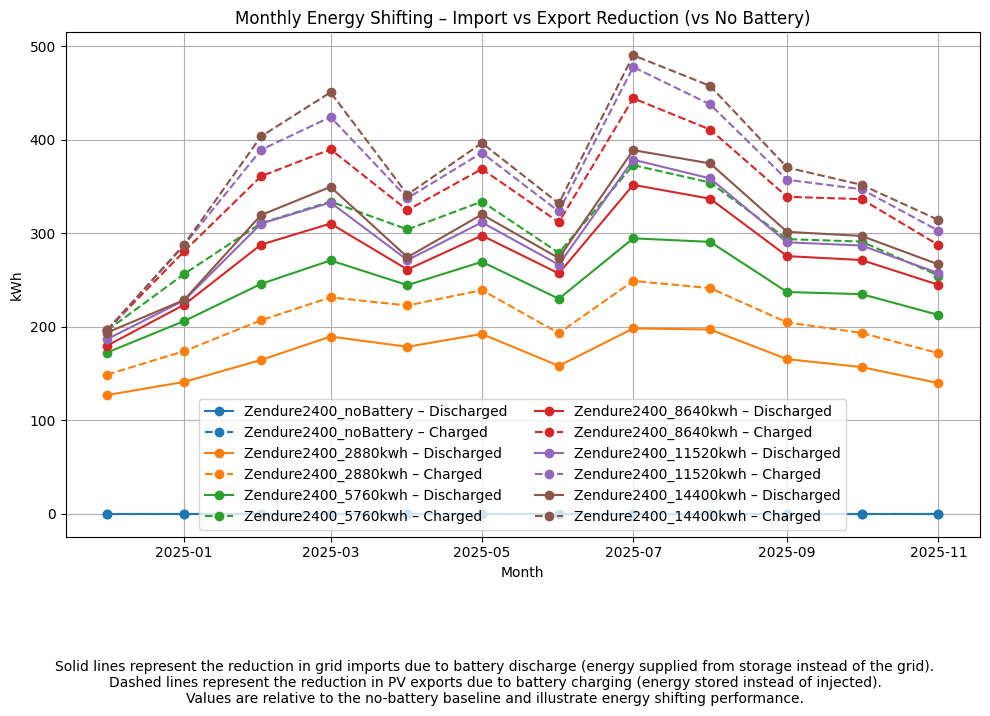

In [227]:
plt.figure(figsize=(10, 6))

color_cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]

for i, scenario in enumerate(scenario_order):
    subset = (
        df_monthly[df_monthly["scenario"] == scenario]
        .sort_values("month")
    )

    color = color_cycle[i % len(color_cycle)]

    # Discharged effect (grid consumption reduction) – solid
    plt.plot(
        subset["month"],
        subset["grid_consumed_kwh"],
        marker="o",
        linestyle="-",
        color=color,
        label=f"{scenario} – Discharged"
    )

    # Charged effect (grid injection increase) – dashed
    plt.plot(
        subset["month"],
        subset["grid_injected_kwh"],
        marker="o",
        linestyle="--",
        color=color,
        label=f"{scenario} – Charged"
    )

plt.title("Monthly Energy Shifting – Import vs Export Reduction (vs No Battery)")
plt.xlabel("Month")
plt.ylabel("kWh")
plt.legend(ncol=2)
plt.grid(True)
plt.tight_layout()
plt.figtext(
    0.5, -0.18,
    "Solid lines represent the reduction in grid imports due to battery discharge "
    "(energy supplied from storage instead of the grid).\n"
    "Dashed lines represent the reduction in PV exports due to battery charging "
    "(energy stored instead of injected).\n"
    "Values are relative to the no-battery baseline and illustrate energy shifting performance.",
    ha="center",
    fontsize=10
)
plt.show()


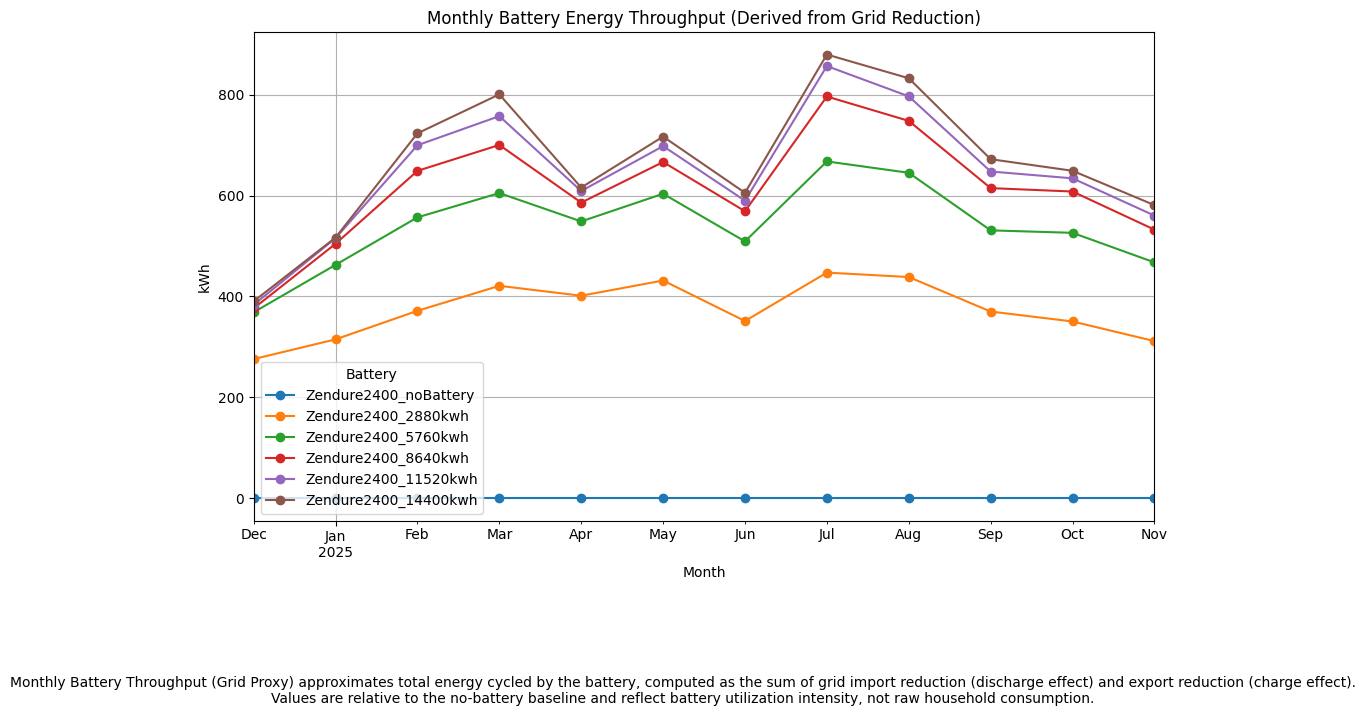

In [242]:
df_monthly["battery_throughput_kwh"] = (
    df_monthly["grid_consumed_kwh"] +
    df_monthly["grid_injected_kwh"]
)

pivot = df_monthly.pivot(
    index="month",
    columns="scenario",
    values="battery_throughput_kwh"
)

pivot = pivot[scenario_order]

pivot.plot(marker="o")
plt.title("Monthly Battery Energy Throughput (Derived from Grid Reduction)")
plt.xlabel("Month")
plt.ylabel("kWh")
plt.legend(title="Battery")
plt.grid(True)
plt.tight_layout()
plt.figtext(
    0.5, -0.18,
    "Monthly Battery Throughput (Grid Proxy) approximates total energy cycled by the battery, "
    "computed as the sum of grid import reduction (discharge effect) and export reduction "
    "(charge effect).\n"
    "Values are relative to the no-battery baseline and reflect battery utilization intensity, "
    "not raw household consumption.",
    ha="center",
    fontsize=10
)
plt.show()


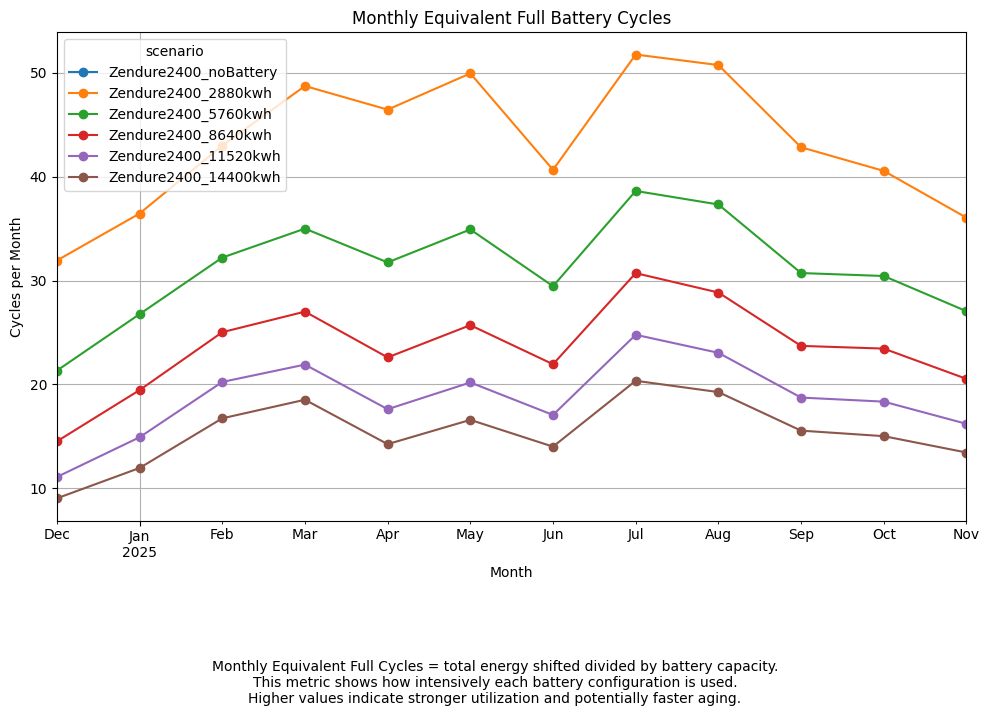

In [259]:
# Convert Wh → kWh
df_monthly["battery_size_kwh"] = df_monthly["battery_size_wh"] / 1000

# Monthly equivalent full cycles
df_monthly["monthly_cycles"] = (
    df_monthly["battery_throughput_kwh"] /
    df_monthly["battery_size_kwh"]
)

pivot_cycles = df_monthly.pivot(
    index="month",
    columns="scenario",
    values="monthly_cycles"
)

pivot_cycles = pivot_cycles[scenario_order]

pivot_cycles.plot(marker="o")

plt.title("Monthly Equivalent Full Battery Cycles")
plt.xlabel("Month")
plt.ylabel("Cycles per Month")
plt.grid(True)
plt.tight_layout()

plt.figtext(
    0.5, -0.18,
    "Monthly Equivalent Full Cycles = total energy shifted divided by battery capacity.\n"
    "This metric shows how intensively each battery configuration is used.\n"
    "Higher values indicate stronger utilization and potentially faster aging.",
    ha="center",
    fontsize=10
)

plt.show()


In [229]:
FULL_ROWS = []

for file in FILES:
    scenario = pathlib.Path(file).stem.replace("config_", "")
    data = load_json(file)

    months = data.get("months", [])
    if not months:
        continue

    for m in months:
        month_range = m.get("range", {})

        is_full_month = month_range.get("is_full_month", False)
        n_days = month_range.get("calendar_duration_days", 0)

        if not is_full_month and n_days < 28:
            continue

        month_id = m["range_id"]
        status = m["results"].get("battery", {}).get("status", {})

        full_samples = 0
        total_samples = status.get("samples_analyzed", 0)

        if total_samples == 0:
            continue

        for phase in ["A", "B", "C"]:
            full_samples += (
                status.get(phase, {})
                .get("full", {})
                .get("sample_count", 0)
            )

        FULL_ROWS.append({
            "month": month_id,
            "scenario": scenario,
            "avg_full_pct": 100.0 * full_samples / total_samples
        })

df_monthly_full = pd.DataFrame(FULL_ROWS)
df_monthly_full["month"] = pd.to_datetime(df_monthly_full["month"])


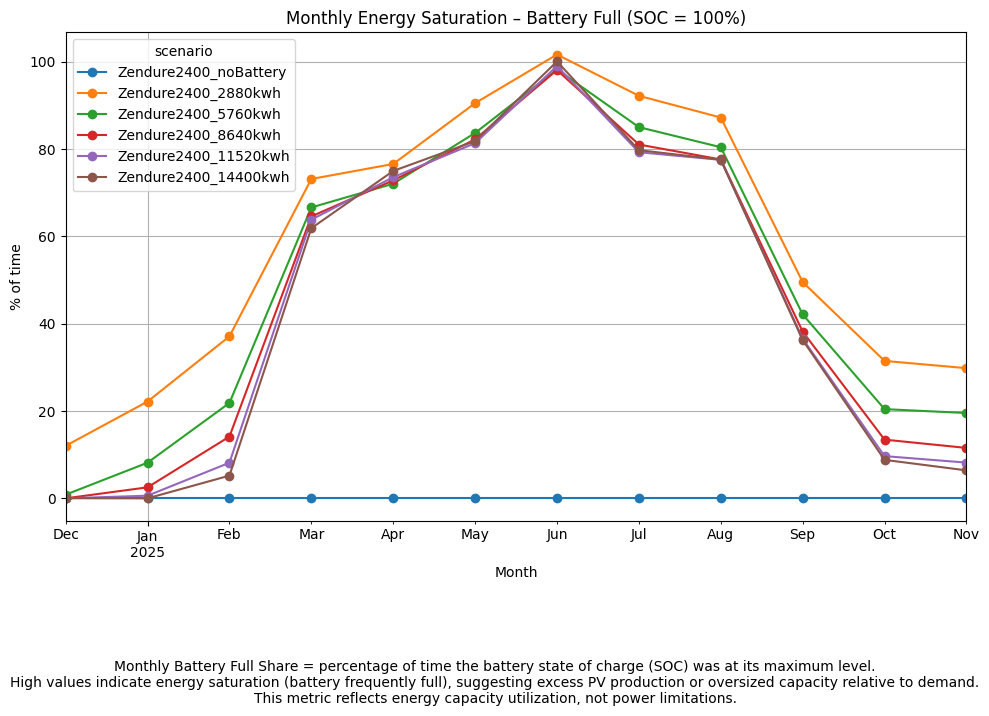

In [243]:
pivot = df_monthly_full.pivot(
    index="month",
    columns="scenario",
    values="avg_full_pct"
)

pivot = pivot[scenario_order]

pivot.plot(marker="o")
plt.title("Monthly Energy Saturation – Battery Full (SOC = 100%)")
plt.xlabel("Month")
plt.ylabel("% of time")
plt.grid(True)
plt.tight_layout()
plt.figtext(
    0.5, -0.18,
    "Monthly Battery Full Share = percentage of time the battery state of charge (SOC) "
    "was at its maximum level.\n"
    "High values indicate energy saturation (battery frequently full), suggesting "
    "excess PV production or oversized capacity relative to demand.\n"
    "This metric reflects energy capacity utilization, not power limitations.",
    ha="center",
    fontsize=10
)
plt.show()


In [231]:
EMPTY_ROWS = []

for file in FILES:
    scenario = pathlib.Path(file).stem.replace("config_", "")
    data = load_json(file)

    months = data.get("months", [])
    if not months:
        continue

    for m in months:
        r = m.get("range", {})
        if not r.get("is_full_month", False) and r.get("calendar_duration_days", 0) < 28:
            continue

        month_id = m["range_id"]
        status = m["results"].get("battery", {}).get("status", {})

        total_samples = status.get("samples_analyzed", 0)
        if total_samples == 0:
            continue

        empty_samples = sum(
            status.get(phase, {})
                  .get("empty", {})
                  .get("sample_count", 0)
            for phase in ["A", "B", "C"]
        )

        # Average across phases (not sum)
        avg_empty_pct = 100.0 * (empty_samples / 3.0) / total_samples

        EMPTY_ROWS.append({
            "month": month_id,
            "scenario": scenario,
            "avg_empty_pct": avg_empty_pct
        })

df_monthly_empty = pd.DataFrame(EMPTY_ROWS)
df_monthly_empty["month"] = pd.to_datetime(df_monthly_empty["month"])


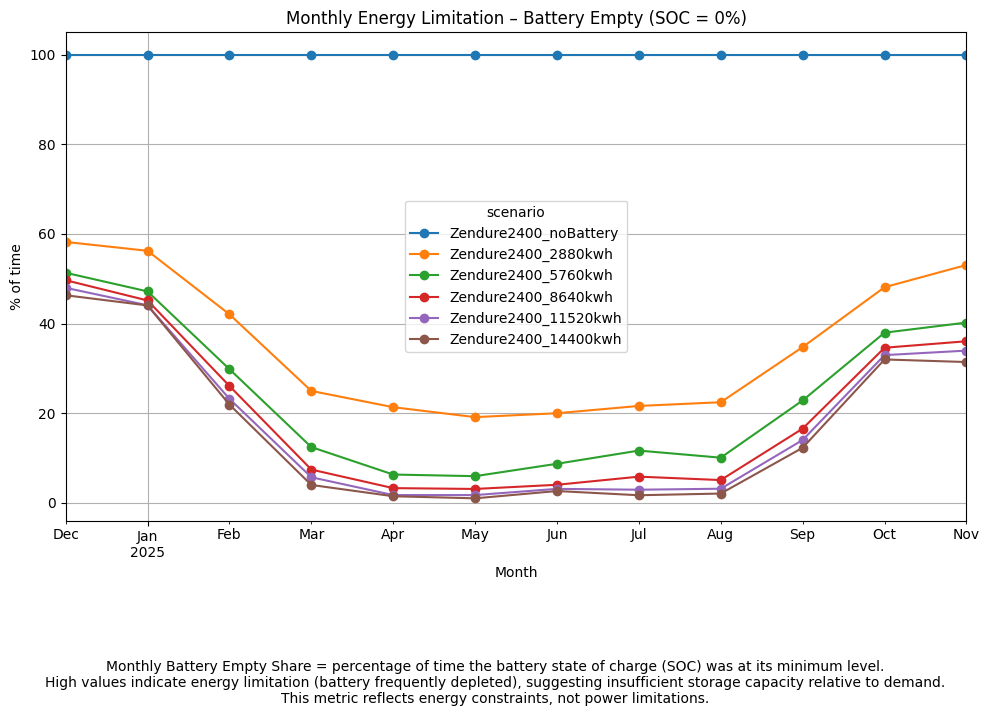

In [244]:
pivot = df_monthly_empty.pivot(
    index="month",
    columns="scenario",
    values="avg_empty_pct"
)

pivot = pivot[scenario_order]

pivot.plot(marker="o")
plt.title("Monthly Energy Limitation – Battery Empty (SOC = 0%)")
plt.xlabel("Month")
plt.ylabel("% of time")
plt.grid(True)
plt.tight_layout()
plt.figtext(
    0.5, -0.18,
    "Monthly Battery Empty Share = percentage of time the battery state of charge (SOC) "
    "was at its minimum level.\n"
    "High values indicate energy limitation (battery frequently depleted), suggesting "
    "insufficient storage capacity relative to demand.\n"
    "This metric reflects energy constraints, not power limitations.",
    ha="center",
    fontsize=10
)
plt.show()


In [255]:
UNDERSIZE_ROWS = []

for file in FILES:
    scenario = pathlib.Path(file).stem.replace("config_", "")
    data = load_json(file)

    months = data.get("months", [])
    if not months:
        continue

    for m in months:
        r = m.get("range", {})

        is_full_month = r.get("is_full_month", False)
        n_days = r.get("calendar_duration_days", 0)

        if not is_full_month and n_days < 28:
            continue

        month_id = m["range_id"]

        battery_block = m.get("results", {}).get("battery", {})

        energy_undersize = battery_block.get("energy_undersize_days", {})
        evening_undersize = battery_block.get("evening_undersize_days", {})

        UNDERSIZE_ROWS.append({
            "month": month_id,
            "scenario": scenario,
            "energy_undersize_pct": energy_undersize.get("percent", 0.0),
            "evening_undersize_pct": evening_undersize.get("percent", 0.0)
        })

df_monthly_undersize = pd.DataFrame(UNDERSIZE_ROWS)

if not df_monthly_undersize.empty:
    df_monthly_undersize["month"] = pd.to_datetime(df_monthly_undersize["month"])


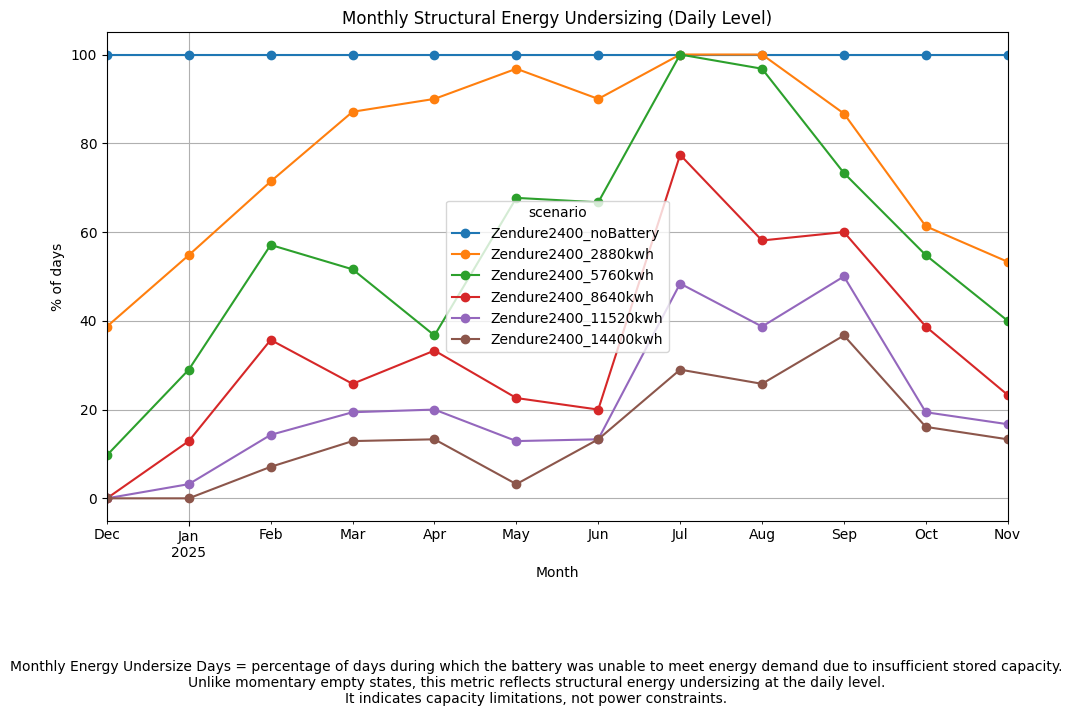

In [256]:
pivot = df_monthly_undersize.pivot(
    index="month",
    columns="scenario",
    values="energy_undersize_pct"
)

pivot = pivot[scenario_order]

pivot.plot(marker="o")
plt.title("Monthly Structural Energy Undersizing (Daily Level)")
plt.xlabel("Month")
plt.ylabel("% of days")
plt.grid(True)
plt.tight_layout()
plt.figtext(
    0.5, -0.18,
    "Monthly Energy Undersize Days = percentage of days during which the battery "
    "was unable to meet energy demand due to insufficient stored capacity.\n"
    "Unlike momentary empty states, this metric reflects structural energy undersizing "
    "at the daily level.\n"
    "It indicates capacity limitations, not power constraints.",
    ha="center",
    fontsize=10
)
plt.show()


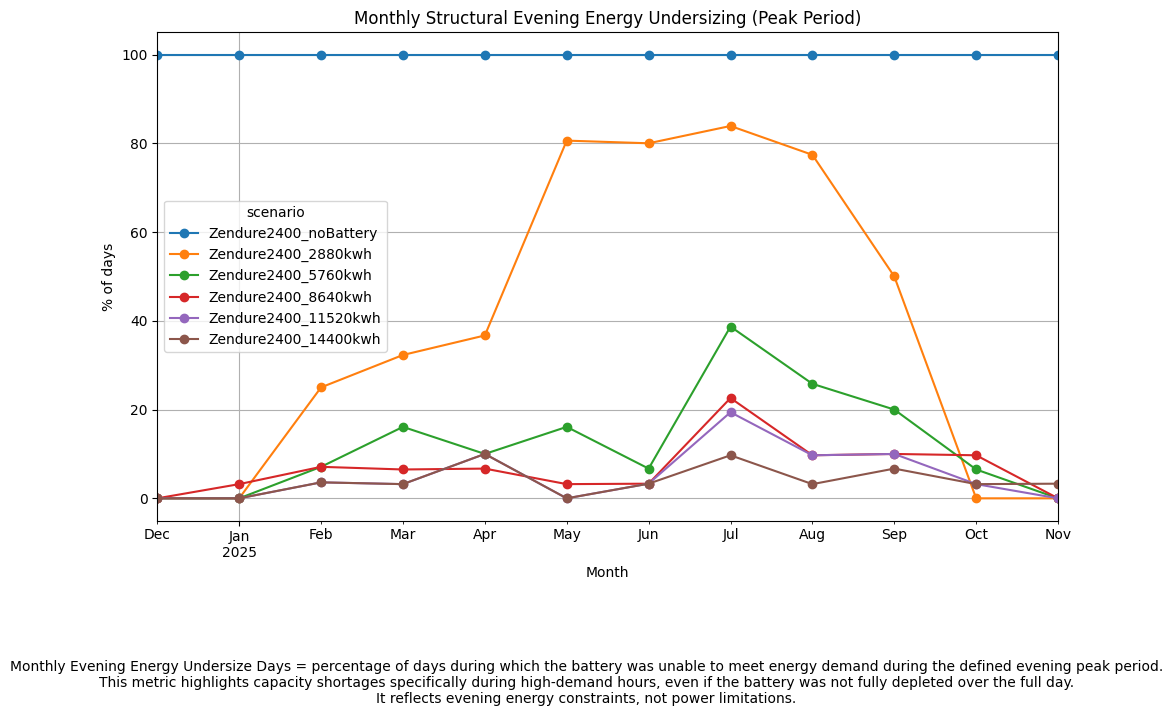

In [257]:
pivot_evening = df_monthly_undersize.pivot(
    index="month",
    columns="scenario",
    values="evening_undersize_pct"
)

pivot_evening = pivot_evening[scenario_order]

pivot_evening.plot(marker="o")

plt.title("Monthly Structural Evening Energy Undersizing (Peak Period)")
plt.xlabel("Month")
plt.ylabel("% of days")
plt.grid(True)
plt.tight_layout()

plt.figtext(
    0.5, -0.18,
    "Monthly Evening Energy Undersize Days = percentage of days during which the battery "
    "was unable to meet energy demand during the defined evening peak period.\n"
    "This metric highlights capacity shortages specifically during high-demand hours, "
    "even if the battery was not fully depleted over the full day.\n"
    "It reflects evening energy constraints, not power limitations.",
    ha="center",
    fontsize=10
)

plt.show()


In [235]:
ACTIVE_POWER_ROWS = []

for file in FILES:
    scenario = pathlib.Path(file).stem.replace("config_", "")
    data = load_json(file)

    months = data.get("months", [])
    if not months:
        continue

    for m in months:
        r = m.get("range", {})
        if not r.get("is_full_month", False) and r.get("calendar_duration_days", 0) < 28:
            continue

        pu = m["results"].get("battery", {}).get("power_usage", {})
        total_samples = pu.get("samples_analyzed", 0)
        if total_samples == 0:
            continue

        active_at_max_samples = (
            sum(
                pu.get("charging", {})
                  .get(p, {})
                  .get("at_max", {})
                  .get("sample_count", 0)
                for p in ["A", "B", "C"]
            )
            +
            sum(
                pu.get("discharging", {})
                  .get(p, {})
                  .get("at_max", {})
                  .get("sample_count", 0)
                for p in ["A", "B", "C"]
            )
        )

        ACTIVE_POWER_ROWS.append({
            "month": m["range_id"],
            "scenario": scenario,
            "active_power_at_max_pct": 100.0 * active_at_max_samples / total_samples
        })

df_monthly_active_power_sat = pd.DataFrame(ACTIVE_POWER_ROWS)
df_monthly_active_power_sat["month"] = pd.to_datetime(df_monthly_active_power_sat["month"])


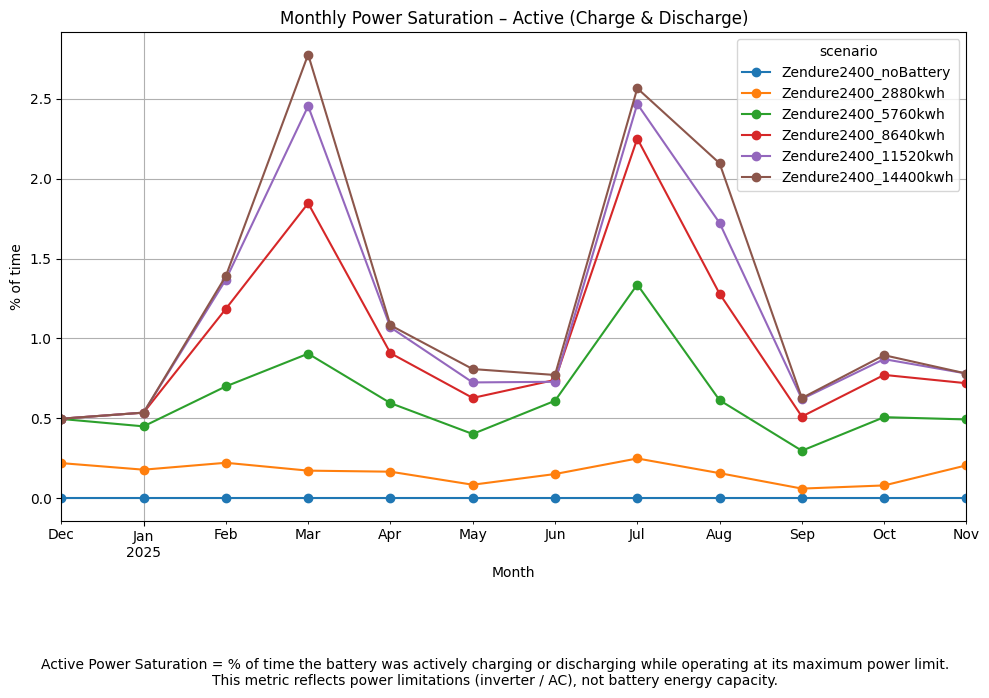

In [246]:
pivot = df_monthly_active_power_sat.pivot(
    index="month",
    columns="scenario",
    values="active_power_at_max_pct"
)

pivot = pivot[scenario_order]

pivot.plot(marker="o")
plt.title("Monthly Power Saturation – Active (Charge & Discharge)")
plt.xlabel("Month")
plt.ylabel("% of time")
plt.grid(True)
plt.tight_layout()
plt.figtext(
    0.5, -0.15,
    "Active Power Saturation = % of time the battery was actively charging or discharging "
    "while operating at its maximum power limit.\n"
    "This metric reflects power limitations (inverter / AC), not battery energy capacity.",
    ha="center",
    fontsize=10
)
plt.show()


In [237]:
IDLE_POWER_ROWS = []

for file in FILES:
    scenario = pathlib.Path(file).stem.replace("config_", "")
    data = load_json(file)

    months = data.get("months", [])
    if not months:
        continue

    for m in months:
        r = m.get("range", {})
        if not r.get("is_full_month", False) and r.get("calendar_duration_days", 0) < 28:
            continue

        pu = m["results"].get("battery", {}).get("power_usage", {})
        total_samples = pu.get("samples_analyzed", 0)
        if total_samples == 0:
            continue

        idle_power_limited_samples = (
            sum(
                pu.get("idle", {})
                  .get(p, {})
                  .get("could_charge_at_max", {})
                  .get("sample_count", 0)
                for p in ["A", "B", "C"]
            )
            +
            sum(
                pu.get("idle", {})
                  .get(p, {})
                  .get("could_discharge_at_max", {})
                  .get("sample_count", 0)
                for p in ["A", "B", "C"]
            )
        )

        IDLE_POWER_ROWS.append({
            "month": m["range_id"],
            "scenario": scenario,
            "idle_power_limited_pct": 100.0 * idle_power_limited_samples / total_samples
        })

df_monthly_idle_power_limited = pd.DataFrame(IDLE_POWER_ROWS)
df_monthly_idle_power_limited["month"] = pd.to_datetime(df_monthly_idle_power_limited["month"])


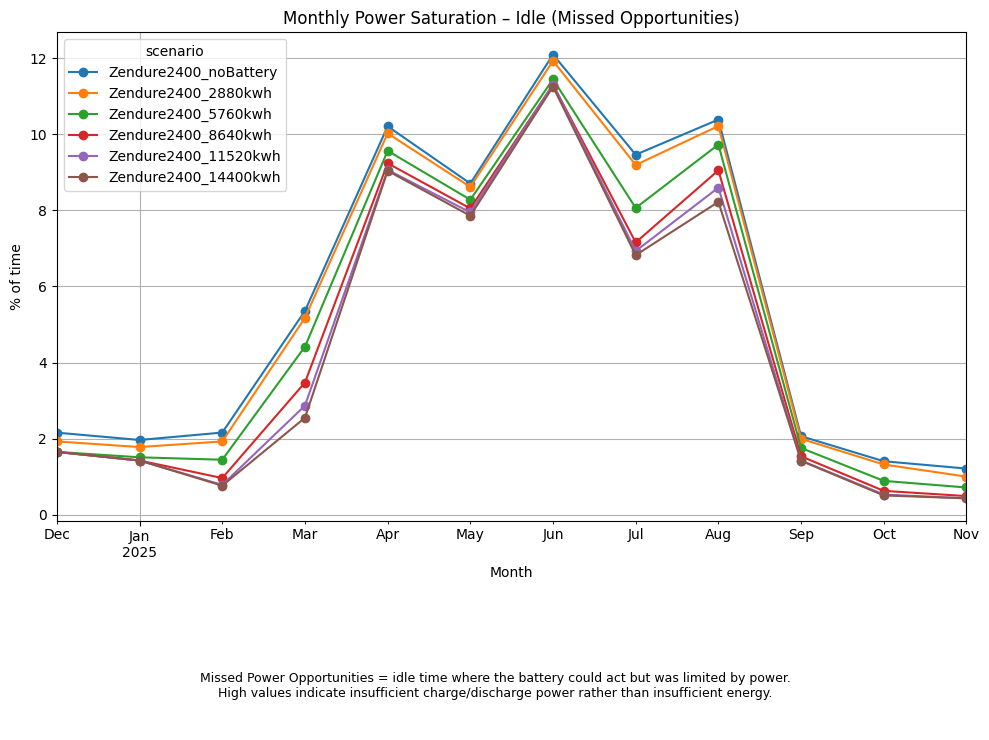

In [247]:
pivot = df_monthly_idle_power_limited.pivot(
    index="month",
    columns="scenario",
    values="idle_power_limited_pct"
)

pivot = pivot[scenario_order]

pivot.plot(marker="o")
plt.title("Monthly Power Saturation – Idle (Missed Opportunities)")
plt.xlabel("Month")
plt.ylabel("% of time")
plt.grid(True)
plt.tight_layout()
plt.figtext(
    0.5, -0.22,
    "Missed Power Opportunities = idle time where the battery could act but was limited by power.\n"
    "High values indicate insufficient charge/discharge power rather than insufficient energy.\n\n",
    ha="center",
    fontsize=9
)
plt.show()


In [239]:
POWER_STACK_ROWS = []

for file in FILES:
    scenario = pathlib.Path(file).stem.replace("config_", "")
    data = load_json(file)

    months = data.get("months", [])
    if not months:
        continue

    for m in months:
        r = m.get("range", {})
        if not r.get("is_full_month", False) and r.get("calendar_duration_days", 0) < 28:
            continue

        pu = m["results"].get("battery", {}).get("power_usage", {})
        total_samples = pu.get("samples_analyzed", 0)
        if total_samples == 0:
            continue

        def sum_samples(mode, phase_key):
            return sum(
                pu.get(mode, {})
                .get(p, {})
                .get(phase_key, {})
                .get("sample_count", 0)
                for p in ["A", "B", "C"]
            )

        POWER_STACK_ROWS.append({
            "month": m["range_id"],
            "scenario": scenario,

            "charging_at_max_pct": 100 * sum_samples("charging", "at_max") / total_samples,
            "charging_not_at_max_pct": 100 * sum_samples("charging", "not_at_max") / total_samples,

            "discharging_at_max_pct": 100 * sum_samples("discharging", "at_max") / total_samples,
            "discharging_not_at_max_pct": 100 * sum_samples("discharging", "not_at_max") / total_samples,

            "idle_could_charge_at_max_pct": 100 * sum_samples("idle", "could_charge_at_max") / total_samples,
            "idle_could_charge_not_at_max_pct": 100 * sum_samples("idle", "could_charge_not_at_max") / total_samples,

            "idle_could_discharge_at_max_pct": 100 * sum_samples("idle", "could_discharge_at_max") / total_samples,
            "idle_could_discharge_not_at_max_pct": 100 * sum_samples("idle", "could_discharge_not_at_max") / total_samples,

        })

df_monthly_power_stack = pd.DataFrame(POWER_STACK_ROWS)
df_monthly_power_stack["month"] = pd.to_datetime(df_monthly_power_stack["month"])


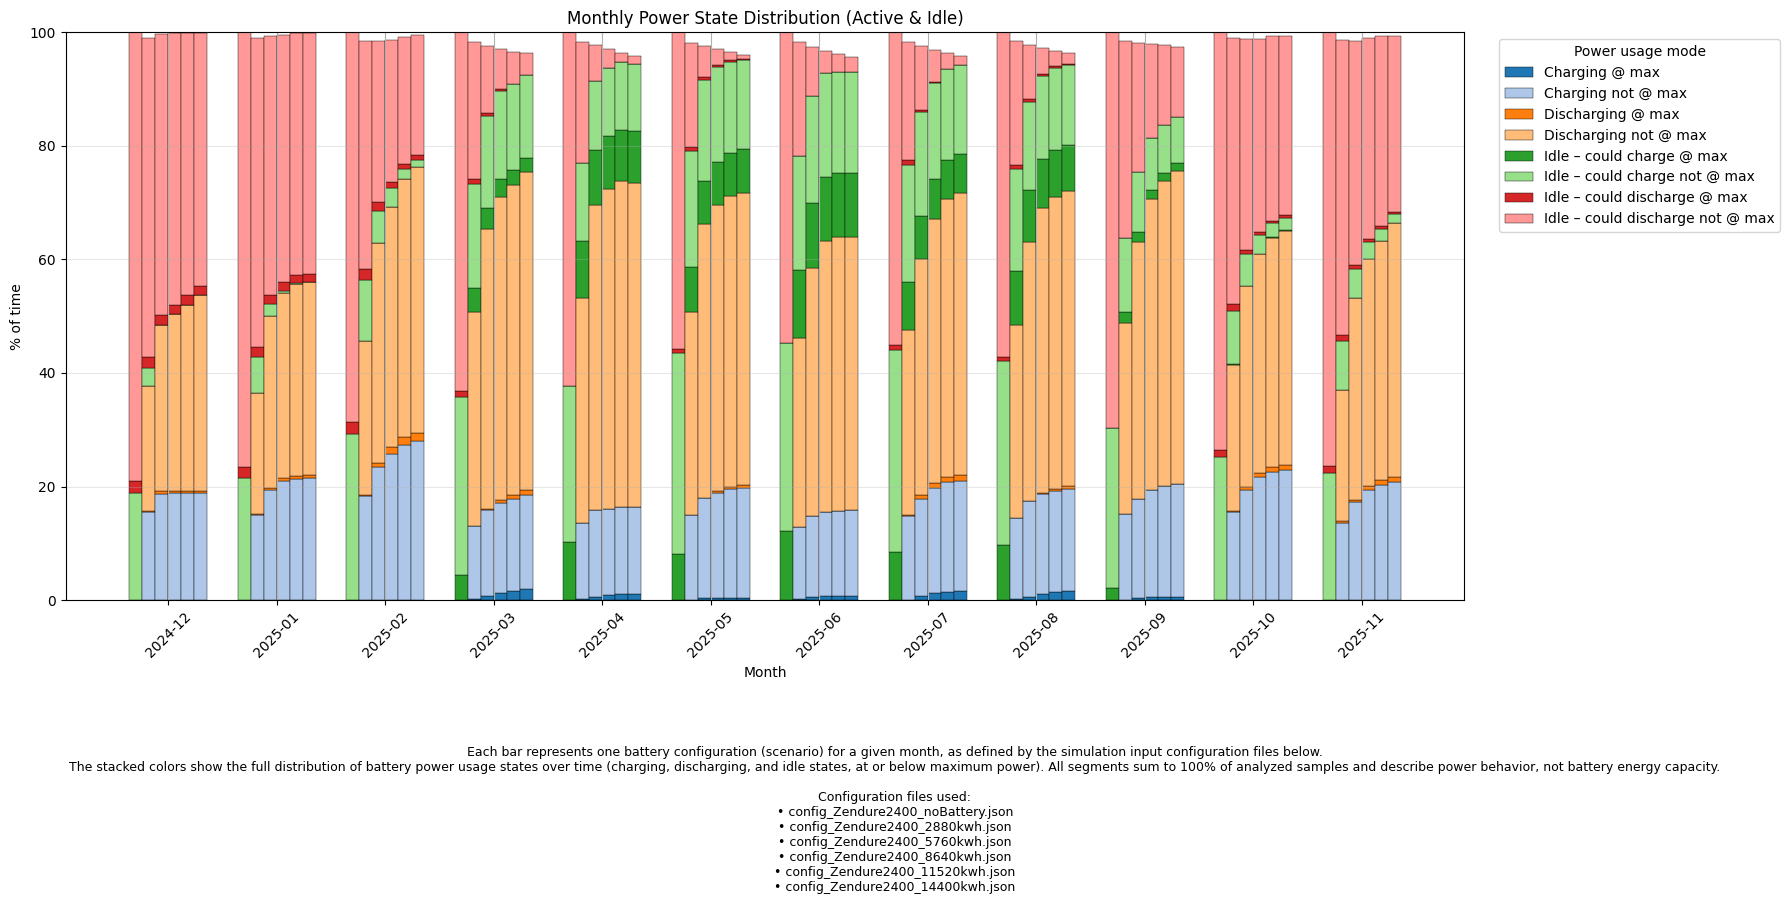

In [248]:
STACK_COMPONENTS = [
    # Charging
    ("charging_at_max_pct", "Charging @ max", "#1f77b4"),
    ("charging_not_at_max_pct", "Charging not @ max", "#aec7e8"),

    # Discharging
    ("discharging_at_max_pct", "Discharging @ max", "#ff7f0e"),
    ("discharging_not_at_max_pct", "Discharging not @ max", "#ffbb78"),

    # Idle – could charge
    ("idle_could_charge_at_max_pct", "Idle – could charge @ max", "#2ca02c"),
    ("idle_could_charge_not_at_max_pct", "Idle – could charge not @ max", "#98df8a"),

    # Idle – could discharge
    ("idle_could_discharge_at_max_pct", "Idle – could discharge @ max", "#d62728"),
    ("idle_could_discharge_not_at_max_pct", "Idle – could discharge not @ max", "#ff9896"),
]

months = sorted(df_monthly_power_stack["month"].unique())
x = np.arange(len(months))
bar_width = 0.12

plt.figure(figsize=(18, 7))

for b_idx, scenario in enumerate(scenario_order):
    subset = (
        df_monthly_power_stack[df_monthly_power_stack["scenario"] == scenario]
        .set_index("month")
        .reindex(months)
    )

    bottom = np.zeros(len(months))
    x_pos = x + b_idx * bar_width

    for col, label, color in STACK_COMPONENTS:
        if col not in subset:
            continue

        values = subset[col].values
        plt.bar(
            x_pos,
            values,
            width=bar_width,
            bottom=bottom,
            color=color,
            edgecolor="black",
            linewidth=0.3,
            label=label if b_idx == 0 else None
        )
        bottom += values

plt.xticks(
    x + bar_width * (len(scenario_order) - 1) / 2,
    [m.strftime("%Y-%m") for m in months],
    rotation=45
)

plt.xlabel("Month")
plt.ylabel("% of time")
plt.ylim(0, 100) 
plt.title("Monthly Power State Distribution (Active & Idle)")
plt.legend(
    title="Power usage mode",
    bbox_to_anchor=(1.02, 1),
    loc="upper left"
)
config_list = "\n".join(
    f"• {pathlib.Path(f).name}" for f in FILES
)

plt.figtext(
    0.5, -0.28,
    "Each bar represents one battery configuration (scenario) for a given month, "
    "as defined by the simulation input configuration files below.\n"
    "The stacked colors show the full distribution of battery power usage states over time "
    "(charging, discharging, and idle states, at or below maximum power). "
    "All segments sum to 100% of analyzed samples and describe power behavior, "
    "not battery energy capacity.\n\n"
    f"Configuration files used:\n{config_list}",
    ha="center",
    fontsize=9
)

plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()
